Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# Lab 5a: Normalization Techniques - Stabilizing Neural Network Training

## Lab Overview

This lab explores normalization techniques that are crucial for training stable and efficient neural networks, particularly in transformer architectures. You'll learn about layer normalization, RMS normalization, and their mathematical foundations.

## Learning Objectives

By the end of this lab, you will:
- Understand the importance of normalization in deep learning
- Master layer normalization and RMS normalization
- Learn about gradient flow and training stability
- Explore normalization in transformer architectures
- Implement custom normalization layers

---

## 1. Environment Setup

In [1]:
# Essential Imports and GPU Setup
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda
PyTorch version: 2.9.1+rocm7.10.0
GPU: Radeon 8060S Graphics
GPU Memory: 103.1 GB


## 2. Normalization Fundamentals

Understanding why normalization is crucial for training deep neural networks and transformer architectures.

In [ ]:
# 2.1 Understanding the Need for Normalization

print("=== Why Normalization Matters ===")

# Create sample input tensor (batch_size=2, seq_len=3, hidden_dim=4)
input_tensor = torch.randn(2, 3, 4, requires_grad=True, device=device)
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Input tensor:\n{input_tensor}")

# Analyze statistics across different dimensions
print("\nStatistics Analysis:")
print(f"  Overall mean: {input_tensor.mean().item():.4f}")
print(f"  Overall std: {input_tensor.std().item():.4f}")

# Statistics across the last dimension (feature dimension)
mean_last_dim = input_tensor.mean(dim=-1, keepdim=True)
std_last_dim = input_tensor.std(dim=-1, keepdim=True)

print("\nPer-sample, per-position statistics (across features):")
print(f"  Mean shape: {mean_last_dim.shape}")
print(f"  Mean values:\n{mean_last_dim}")
print(f"  Std values:\n{std_last_dim}")

# Show the problem: activations can have very different scales
print("\nActivation Scale Problems:")
large_input = input_tensor * 100  # Simulate large activations
small_input = input_tensor * 0.01  # Simulate small activations

print(f"  Large activations range: [{large_input.min().item():.2f}, {large_input.max().item():.2f}]")
print(f"  Small activations range: [{small_input.min().item():.6f}, {small_input.max().item():.6f}]")

print("\nNormalization solves:")
print("  - Activation scale variations")
print("  - Internal covariate shift")
print("  - Gradient flow problems")
print("  - Training instability")

# Variance epsilon for numerical stability
variance_epsilon = 1e-6
print(f"\nVariance epsilon: {variance_epsilon} (prevents division by zero)")

=== Why Normalization Matters ===
Input tensor shape: torch.Size([2, 3, 4])
Input tensor:
tensor([[[ 0.1940,  2.1614, -0.1721,  0.8491],
         [-1.9244,  0.6530, -0.6494, -0.8175],
         [ 0.5280, -1.2753, -1.6621, -0.3033]],

        [[-0.0926,  0.1992, -1.1204,  1.8577],
         [-0.7145,  0.6881,  0.7968, -0.0334],
         [ 1.4917, -0.5165, -0.2541,  1.4746]]], device='cuda:0',
       requires_grad=True)

Statistics Analysis:
  Overall mean: 0.0566
  Overall std: 1.0728

Per-sample, per-position statistics (across features):
  Mean shape: torch.Size([2, 3, 1])
  Mean values:
tensor([[[ 0.7581],
         [-0.6846],
         [-0.6782]],

        [[ 0.2110],
         [ 0.1843],
         [ 0.5489]]], device='cuda:0', grad_fn=<MeanBackward1>)
  Std values:
tensor([[[1.0265],
         [1.0560],
         [0.9866]],

        [[1.2351],
         [0.7034],
         [1.0841]]], device='cuda:0', grad_fn=<StdBackward0>)

Activation Scale Problems:
  Large activations range: [-192.44, 21

In [ ]:
# 2.2 RMS Normalization Implementation

print("=== RMS (Root Mean Square) Normalization ===")

# Ensure input is float32 for stability
input_tensor = input_tensor.to(torch.float32)
print(f"Input tensor dtype: {input_tensor.dtype}")

# Manual RMS Normalization implementation
print("\nManual RMS Normalization:")
print("1. Compute variance (mean of squared values)")
variance = input_tensor.pow(2).mean(dim=-1, keepdim=True)
print(f"   Variance shape: {variance.shape}")
print(f"   Variance values:\n{variance}")

print("\n2. Compute RMS normalization")
rms_normalized = input_tensor * torch.rsqrt(variance + variance_epsilon)
print(f"   RMS normalized shape: {rms_normalized.shape}")
print(f"   RMS normalized:\n{rms_normalized}")

# Verify normalization properties
print("\n3. Verify normalization properties:")
normalized_variance = rms_normalized.pow(2).mean(dim=-1, keepdim=True)
print(f"   Normalized variance (should be ~1.0):\n{normalized_variance}")

# Compare with PyTorch's RMSNorm
print("\nPyTorch RMSNorm comparison:")
try:
    # PyTorch RMSNorm (available in newer versions)
    rms_layer = nn.RMSNorm([4], device=device)
    pytorch_rms_result = rms_layer(input_tensor)

    print(f"   PyTorch RMSNorm output:\n{pytorch_rms_result}")
    print(f"   Results match: {torch.allclose(rms_normalized, pytorch_rms_result, atol=1e-5)}")

except AttributeError:
    print("   RMSNorm not available in this PyTorch version")
    print("   Using manual implementation")

# RMS vs Layer Normalization comparison
print("\nRMS vs Layer Normalization:")
layer_norm = nn.LayerNorm(4, device=device)
layer_norm_result = layer_norm(input_tensor)

print(f"   RMS Norm output mean: {rms_normalized.mean(dim=-1)}")
print(f"   Layer Norm output mean: {layer_norm_result.mean(dim=-1)}")
print("   Layer Norm has zero mean, RMS Norm doesn't")

print("\nRMS Normalization benefits:")
print("  - Simpler computation (no mean subtraction)")
print("  - Fewer parameters (no bias term)")
print("  - Used in modern architectures like LLaMA")
print("  - More stable for very deep networks")

=== RMS (Root Mean Square) Normalization ===
Input tensor dtype: torch.float32

Manual RMS Normalization:
1. Compute variance (mean of squared values)
   Variance shape: torch.Size([2, 3, 1])
   Variance values:
tensor([[[1.3649],
         [1.3050],
         [1.1900]],

        [[1.1886],
         [0.4050],
         [1.1828]]], device='cuda:0', grad_fn=<MeanBackward1>)

2. Compute RMS normalization
   RMS normalized shape: torch.Size([2, 3, 4])
   RMS normalized:
tensor([[[ 0.1661,  1.8500, -0.1473,  0.7267],
         [-1.6846,  0.5716, -0.5685, -0.7157],
         [ 0.4840, -1.1691, -1.5237, -0.2780]],

        [[-0.0849,  0.1827, -1.0277,  1.7039],
         [-1.1227,  1.0812,  1.2521, -0.0525],
         [ 1.3716, -0.4749, -0.2336,  1.3559]]], device='cuda:0',
       grad_fn=<MulBackward0>)

3. Verify normalization properties:
   Normalized variance (should be ~1.0):
tensor([[[1.0000],
         [1.0000],
         [1.0000]],

        [[1.0000],
         [1.0000],
         [1.0000]]], de

In [ ]:
# 2.3 Custom RMS Normalization Layer

print("=== Custom RMS Normalization Implementation ===")


class CustomRMSNorm(nn.Module):
    """
    Custom RMS Normalization layer for educational purposes
    Used in modern transformer architectures like LLaMA
    """

    def __init__(self, hidden_size, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.eps = eps

    def forward(self, hidden_states):
        # Compute RMS
        variance = hidden_states.pow(2).mean(dim=-1, keepdim=True)
        hidden_states = hidden_states * torch.rsqrt(variance + self.eps)

        # Apply learnable scaling
        return self.weight * hidden_states


# Test custom implementation
print("Testing Custom RMS Normalization:")
custom_rms = CustomRMSNorm(hidden_size=4).to(device)
print(f"  Initial weight parameter: {custom_rms.weight}")

# Apply normalization
custom_output = custom_rms(input_tensor)
print(f"  Custom RMS output shape: {custom_output.shape}")
print(f"  Custom RMS output:\n{custom_output}")

# Verify learnable parameters
print("\nLearnable Parameters:")
for name, param in custom_rms.named_parameters():
    print(f"  {name}: shape {param.shape}, requires_grad={param.requires_grad}")

# Compare different normalization approaches
print("\nNormalization Comparison:")
test_input = torch.randn(1, 1, 4, device=device)

# No normalization
print(f"  Original: {test_input.squeeze()}")

# Custom RMS
rms_output = custom_rms(test_input)
print(f"  RMS Norm: {rms_output.squeeze()}")

# Layer normalization
layer_norm_output = layer_norm(test_input)
print(f"  Layer Norm: {layer_norm_output.squeeze()}")

# Statistics comparison
print("\nStatistics Comparison:")
print(f"  Original - Mean: {test_input.mean():.4f}, Std: {test_input.std():.4f}")
print(f"  RMS Norm - Mean: {rms_output.mean():.4f}, Std: {rms_output.std():.4f}")
print(f"  Layer Norm - Mean: {layer_norm_output.mean():.4f}, Std: {layer_norm_output.std():.4f}")

print("\nKey Differences:")
print("  - RMS Norm: Only normalizes variance, preserves mean structure")
print("  - Layer Norm: Normalizes both mean and variance to 0 and 1")
print("  - Both use learnable scaling parameters")

=== Custom RMS Normalization Implementation ===
Testing Custom RMS Normalization:
  Initial weight parameter: Parameter containing:
tensor([1., 1., 1., 1.], device='cuda:0', requires_grad=True)
  Custom RMS output shape: torch.Size([2, 3, 4])
  Custom RMS output:
tensor([[[ 0.1661,  1.8500, -0.1473,  0.7267],
         [-1.6846,  0.5716, -0.5685, -0.7157],
         [ 0.4840, -1.1691, -1.5237, -0.2780]],

        [[-0.0849,  0.1827, -1.0277,  1.7039],
         [-1.1227,  1.0812,  1.2521, -0.0525],
         [ 1.3716, -0.4749, -0.2336,  1.3559]]], device='cuda:0',
       grad_fn=<MulBackward0>)

Learnable Parameters:
  weight: shape torch.Size([4]), requires_grad=True

Normalization Comparison:
  Original: tensor([ 0.1391, -0.1082, -0.7174,  0.7566], device='cuda:0')
  RMS Norm: tensor([ 0.2631, -0.2047, -1.3568,  1.4310], device='cuda:0',
       grad_fn=<SqueezeBackward0>)
  Layer Norm: tensor([ 0.2301, -0.2380, -1.3907,  1.3986], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

Stati

In [ ]:
# 3. Positional Encoding in Transformers

print("=== Sinusoidal Positional Encoding ===")


class SinusoidalPositionalEncoding(nn.Module):
    """
    Sinusoidal positional encoding as used in the original Transformer paper
    Provides position information to the model without learned parameters
    """

    def __init__(self, dim=128, max_seq_len=512, base=10000):
        super().__init__()
        self.dim = dim
        self.base = base
        self.max_seq_len = max_seq_len

        # Pre-compute positional encodings
        pe = torch.zeros(max_seq_len, dim)

        # Position indices
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        print(f"Position tensor shape: {position.shape}")

        # Frequency computation
        div_term = torch.exp(torch.arange(0, dim, 2).float() * -(torch.log(torch.tensor(base)) / dim))
        print(f"Division term shape: {div_term.shape}")
        print(f"First few frequency values: {div_term[:5]}")

        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer (not a parameter, but part of state)
        self.register_buffer("pe", pe)

    def forward(self, position_ids):
        """
        Args:
            position_ids: tensor of shape [seq_len] or [batch_size, seq_len]
        Returns:
            positional encodings of shape [seq_len, dim] or [batch_size, seq_len, dim]
        """
        if position_ids.dim() == 1:
            return self.pe[position_ids]
        else:
            # Handle batch of position_ids
            return self.pe[position_ids]


# Test positional encoding
print("\nTesting Positional Encoding:")
pe_layer = SinusoidalPositionalEncoding(dim=128, max_seq_len=10)

# Test with simple position sequence
positions = torch.arange(5)
pos_encodings = pe_layer(positions)

print(f"Position encodings shape: {pos_encodings.shape}")
print(f"First position encoding (pos=0): {pos_encodings[0][:8]}")
print(f"Second position encoding (pos=1): {pos_encodings[1][:8]}")

# Visualize positional encoding patterns
print("\nPositional Encoding Properties:")
pe_matrix = pe_layer.pe[:8, :16]  # First 8 positions, first 16 dimensions
print(f"PE matrix shape for visualization: {pe_matrix.shape}")

# Check orthogonality (different positions should be distinguishable)
pos_0 = pe_layer.pe[0]
pos_1 = pe_layer.pe[1]
pos_4 = pe_layer.pe[4]

similarity_01 = F.cosine_similarity(pos_0, pos_1, dim=0)
similarity_04 = F.cosine_similarity(pos_0, pos_4, dim=0)

print(f"Cosine similarity between pos 0 and 1: {similarity_01:.4f}")
print(f"Cosine similarity between pos 0 and 4: {similarity_04:.4f}")

print("\nPositional Encoding Benefits:")
print("  - Provides absolute position information")
print("  - No learned parameters (deterministic)")
print("  - Can extrapolate to longer sequences")
print("  - Preserves relative position relationships")
print("  - Essential for transformer attention mechanisms")

=== Sinusoidal Positional Encoding ===

Testing Positional Encoding:
Position tensor shape: torch.Size([10, 1])
Division term shape: torch.Size([64])
First few frequency values: tensor([1.0000, 0.8660, 0.7499, 0.6494, 0.5623])
Position encodings shape: torch.Size([5, 128])
First position encoding (pos=0): tensor([0., 1., 0., 1., 0., 1., 0., 1.])
Second position encoding (pos=1): tensor([0.8415, 0.5403, 0.7617, 0.6479, 0.6816, 0.7318, 0.6047, 0.7965])

Positional Encoding Properties:
PE matrix shape for visualization: torch.Size([8, 16])
Cosine similarity between pos 0 and 1: 0.9702
Cosine similarity between pos 0 and 4: 0.7592

Positional Encoding Benefits:
  - Provides absolute position information
  - No learned parameters (deterministic)
  - Can extrapolate to longer sequences
  - Preserves relative position relationships
  - Essential for transformer attention mechanisms


=== Activation Function Analysis ===
Analyzing activation functions over range [-5.0, 4.9]


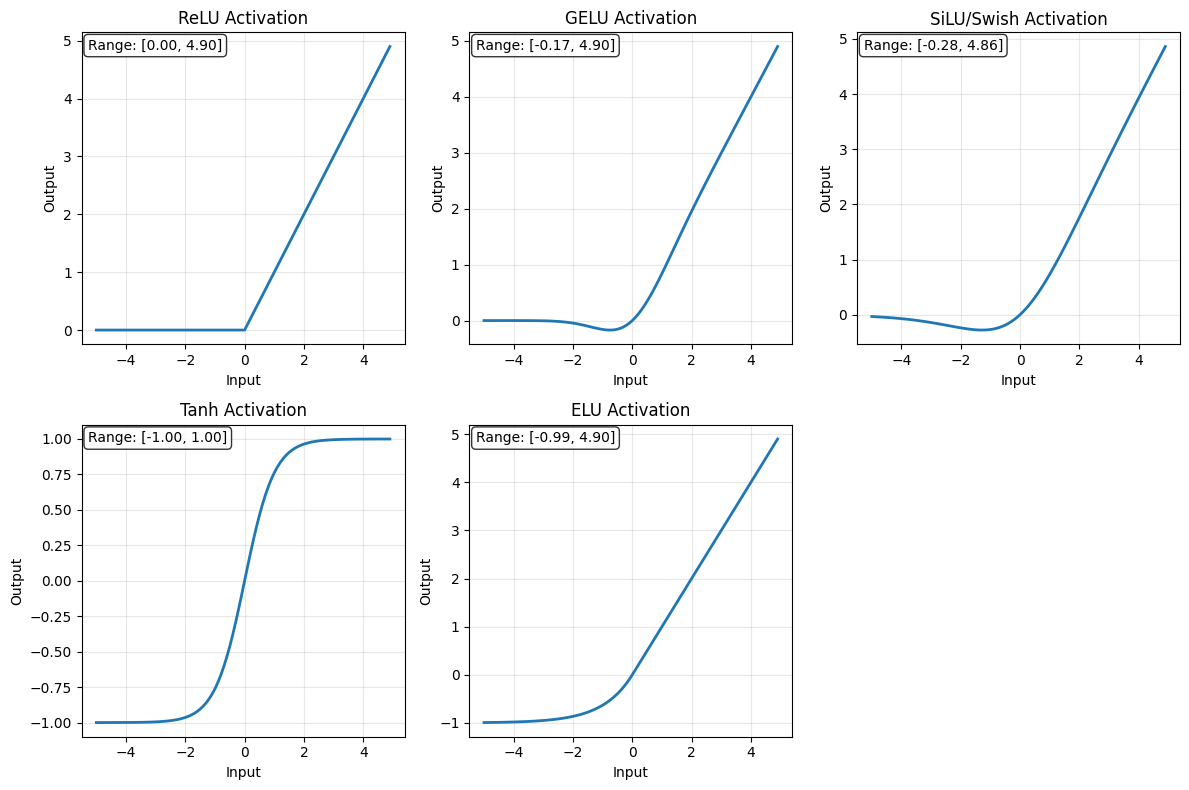


Activation Function Properties:
Test inputs: tensor([-2.0000, -0.5000,  0.0000,  0.5000,  2.0000], device='cuda:0')

ReLU:
  Outputs: tensor([0.0000, 0.0000, 0.0000, 0.5000, 2.0000], device='cuda:0')
  Range: [0.000, 2.000]
  Gradients: tensor([0., 0., 0., 1., 1.], device='cuda:0')
  Gradient range: [0.000, 1.000]

GELU:
  Outputs: tensor([-0.0455, -0.1543,  0.0000,  0.3457,  1.9545], device='cuda:0')
  Range: [-0.154, 1.954]
  Gradients: tensor([-0.0852,  0.1325,  0.5000,  0.8675,  1.0852], device='cuda:0')
  Gradient range: [-0.085, 1.085]

SiLU/Swish:
  Outputs: tensor([-0.2384, -0.1888,  0.0000,  0.3112,  1.7616], device='cuda:0')
  Range: [-0.238, 1.762]
  Gradients: tensor([-0.0908,  0.2600,  0.5000,  0.7400,  1.0908], device='cuda:0')
  Gradient range: [-0.091, 1.091]

Tanh:
  Outputs: tensor([-0.9640, -0.4621,  0.0000,  0.4621,  0.9640], device='cuda:0')
  Range: [-0.964, 0.964]
  Gradients: tensor([0.0707, 0.7864, 1.0000, 0.7864, 0.0707], device='cuda:0')
  Gradient range: [0

In [ ]:
# 4. Activation Functions in Modern Architectures

print("=== Activation Function Analysis ===")

# Create input range for visualization
x_range = torch.arange(-5, 5, 0.1, device=device)

print(f"Analyzing activation functions over range [{x_range.min():.1f}, {x_range.max():.1f}]")

# Common activation functions
activations = {
    "ReLU": F.relu,
    "GELU": F.gelu,
    "SiLU/Swish": F.silu,
    "Tanh": torch.tanh,
    "ELU": F.elu,
}

# Create visualization
plt.figure(figsize=(12, 8))

for i, (name, func) in enumerate(activations.items()):
    y = func(x_range)
    plt.subplot(2, 3, i + 1)
    plt.plot(x_range.cpu(), y.cpu(), label=name, linewidth=2)
    plt.title(f"{name} Activation")
    plt.grid(True, alpha=0.3)
    plt.xlabel("Input")
    plt.ylabel("Output")

    # Add statistics
    positive_region = y[x_range > 0]
    negative_region = y[x_range < 0]

    plt.text(
        0.02,
        0.98,
        f"Range: [{y.min():.2f}, {y.max():.2f}]",
        transform=plt.gca().transAxes,
        verticalalignment="top",
        bbox={"boxstyle": "round", "facecolor": "white", "alpha": 0.8},
    )

plt.tight_layout()
plt.show()

# Analyze activation properties
print("\nActivation Function Properties:")

test_inputs = torch.tensor([-2.0, -0.5, 0.0, 0.5, 2.0], device=device)
print(f"Test inputs: {test_inputs}")

for name, func in activations.items():
    outputs = func(test_inputs)
    print(f"\n{name}:")
    print(f"  Outputs: {outputs}")
    print(f"  Range: [{outputs.min():.3f}, {outputs.max():.3f}]")

    # Check gradient properties (approximate)
    test_input_grad = test_inputs.clone().requires_grad_(True)
    output_grad = func(test_input_grad)
    grad_output = torch.ones_like(output_grad)
    gradients = torch.autograd.grad(output_grad, test_input_grad, grad_output, retain_graph=True)[0]
    print(f"  Gradients: {gradients}")
    print(f"  Gradient range: [{gradients.min():.3f}, {gradients.max():.3f}]")

print("\nActivation Function Usage in Modern LLMs:")
print("  - GELU: Used in BERT, GPT-2, many transformers")
print("  - SiLU (Swish): Used in Transformer-XL, some modern architectures")
print("  - ReLU: Classic choice, simple but can cause dead neurons")
print("  - GELU provides smooth, non-monotonic activation")
print("  - SiLU combines properties of sigmoid and linear functions")

In [ ]:
# 5. Feed-Forward Networks in Transformers

print("=== Transformer Feed-Forward Network ===")


class TransformerFFN(nn.Module):
    """
    Feed-Forward Network as used in Transformer architectures
    Two linear transformations with activation and dropout
    """

    def __init__(self, hidden_size=768, ffn_size=3072, activation="gelu", dropout_p=0.1):
        super().__init__()

        self.hidden_size = hidden_size
        self.ffn_size = ffn_size
        self.dropout_p = dropout_p

        # Linear transformations
        self.up_proj = nn.Linear(hidden_size, ffn_size)
        self.down_proj = nn.Linear(ffn_size, hidden_size)

        # Activation function selection
        if activation == "relu":
            self.activation_func = F.relu
        elif activation == "gelu":
            self.activation_func = F.gelu
        elif activation == "silu":
            self.activation_func = F.silu
        else:
            self.activation_func = F.gelu  # Default

        self.dropout = nn.Dropout(p=dropout_p)

    def forward(self, hidden_states):
        """
        Args:
            hidden_states: [batch_size, seq_len, hidden_size]
        Returns:
            output: [batch_size, seq_len, hidden_size]
        """
        # Expand to larger dimension
        expanded = self.up_proj(hidden_states)  # [batch_size, seq_len, ffn_size]

        # Apply activation
        activated = self.activation_func(expanded)

        # Apply dropout for regularization
        dropped = self.dropout(activated)

        # Project back to original dimension
        output = self.down_proj(dropped)  # [batch_size, seq_len, hidden_size]

        return output


# Test different configurations
print("Testing FFN with different configurations:")

configurations = [
    {"hidden_size": 512, "ffn_size": 2048, "activation": "gelu"},
    {"hidden_size": 768, "ffn_size": 3072, "activation": "relu"},
    {"hidden_size": 1024, "ffn_size": 4096, "activation": "silu"},
]

test_input = torch.randn(2, 8, 512, device=device)  # [batch=2, seq_len=8, hidden=512]

for i, config in enumerate(configurations):
    print(f"\nConfiguration {i + 1}: {config}")

    # Create FFN with specific configuration
    ffn = TransformerFFN(**config).to(device)

    # Count parameters
    total_params = sum(p.numel() for p in ffn.parameters())
    print(f"  Total parameters: {total_params:,}")

    # Test forward pass (adjust input size if needed)
    if config["hidden_size"] != test_input.size(-1):
        current_input = torch.randn(2, 8, config["hidden_size"], device=device)
    else:
        current_input = test_input

    output = ffn(current_input)
    print(f"  Input shape: {current_input.shape}")
    print(f"  Output shape: {output.shape}")
    print(f"  Output mean: {output.mean().item():.4f}")
    print(f"  Output std: {output.std().item():.4f}")

# Analyze expansion ratio impact
print("\nExpansion Ratio Analysis:")
hidden_size = 768
base_input = torch.randn(1, 10, hidden_size, device=device)

expansion_ratios = [2, 4, 8]
for ratio in expansion_ratios:
    ffn_size = hidden_size * ratio
    ffn = TransformerFFN(hidden_size, ffn_size).to(device)

    # Parameters and computation
    params = sum(p.numel() for p in ffn.parameters())

    # Timing (rough estimate)
    import time

    start_time = time.time()
    with torch.no_grad():
        for _ in range(100):
            _ = ffn(base_input)
    end_time = time.time()

    print(f"  Ratio {ratio}x: {params:,} params, {(end_time - start_time) * 10:.2f}ms per forward pass")

print("\nFFN Design Principles:")
print("  - Expansion ratio typically 4x (768 -> 3072 in BERT)")
print("  - Provides non-linear transformation capability")
print("  - Most parameters in transformer are in FFN layers")
print("  - Dropout prevents overfitting in large networks")
print("  - Activation function choice affects gradient flow")
print("  - Residual connections (added outside) prevent vanishing gradients")

=== Transformer Feed-Forward Network ===
Testing FFN with different configurations:

Configuration 1: {'hidden_size': 512, 'ffn_size': 2048, 'activation': 'gelu'}
  Total parameters: 2,099,712
  Input shape: torch.Size([2, 8, 512])
  Output shape: torch.Size([2, 8, 512])
  Output mean: 0.0007
  Output std: 0.2103

Configuration 2: {'hidden_size': 768, 'ffn_size': 3072, 'activation': 'relu'}
  Total parameters: 4,722,432
  Input shape: torch.Size([2, 8, 768])
  Output shape: torch.Size([2, 8, 768])
  Output mean: -0.0089
  Output std: 0.2492

Configuration 3: {'hidden_size': 1024, 'ffn_size': 4096, 'activation': 'silu'}
  Total parameters: 8,393,728
  Input shape: torch.Size([2, 8, 1024])
  Output shape: torch.Size([2, 8, 1024])
  Output mean: 0.0012
  Output std: 0.1950

Expansion Ratio Analysis:
  Ratio 2x: 2,361,600 params, 0.69ms per forward pass
  Ratio 4x: 4,722,432 params, 0.60ms per forward pass
  Ratio 8x: 9,444,096 params, 0.61ms per forward pass

FFN Design Principles:
  - Ex

## 6. Complete Transformer Block with Normalization

Combining all components: normalization, attention, and feed-forward networks in a complete transformer block.

In [ ]:
# 6.1 Transformer Block with Different Normalization Patterns

print("=== Transformer Block Normalization Patterns ===")


class TransformerBlock(nn.Module):
    """
    Complete Transformer block with configurable normalization
    Supports both Pre-LN and Post-LN patterns
    """

    def __init__(
        self, hidden_size=768, num_heads=12, ffn_size=3072, dropout=0.1, norm_type="layer", norm_position="pre"
    ):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.norm_position = norm_position  # 'pre' or 'post'

        # Multi-head attention (simplified for demonstration)
        self.attention = nn.MultiheadAttention(hidden_size, num_heads, dropout=dropout, batch_first=True)

        # Feed-forward network
        self.ffn = TransformerFFN(hidden_size, ffn_size, dropout_p=dropout)

        # Normalization layers
        if norm_type == "layer":
            self.norm1 = nn.LayerNorm(hidden_size)
            self.norm2 = nn.LayerNorm(hidden_size)
        elif norm_type == "rms":
            self.norm1 = CustomRMSNorm(hidden_size)
            self.norm2 = CustomRMSNorm(hidden_size)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, attention_mask=None):
        """
        Args:
            x: [batch_size, seq_len, hidden_size]
            attention_mask: [batch_size, seq_len] or None
        """
        if self.norm_position == "pre":
            # Pre-LN: Normalize before sub-layers (modern approach)

            # Self-attention with residual connection
            normalized_x = self.norm1(x)
            attn_output, _ = self.attention(normalized_x, normalized_x, normalized_x, key_padding_mask=attention_mask)
            x = x + self.dropout(attn_output)

            # Feed-forward with residual connection
            normalized_x = self.norm2(x)
            ffn_output = self.ffn(normalized_x)
            x = x + self.dropout(ffn_output)

        else:  # post-ln
            # Post-LN: Normalize after sub-layers (original Transformer)

            # Self-attention with residual connection and normalization
            attn_output, _ = self.attention(x, x, x, key_padding_mask=attention_mask)
            x = self.norm1(x + self.dropout(attn_output))

            # Feed-forward with residual connection and normalization
            ffn_output = self.ffn(x)
            x = self.norm2(x + self.dropout(ffn_output))

        return x


# Test different normalization patterns
print("Testing different normalization patterns:")

# Create test input
batch_size, seq_len, hidden_size = 2, 16, 512
test_input = torch.randn(batch_size, seq_len, hidden_size, device=device)

print(f"Input shape: {test_input.shape}")
print(f"Input statistics - Mean: {test_input.mean():.4f}, Std: {test_input.std():.4f}")

# Test configurations
configs = [
    {"norm_type": "layer", "norm_position": "pre", "name": "Pre-LN (LayerNorm)"},
    {"norm_type": "layer", "norm_position": "post", "name": "Post-LN (LayerNorm)"},
    {"norm_type": "rms", "norm_position": "pre", "name": "Pre-LN (RMSNorm)"},
]

for config in configs:
    print(f"\n{config['name']}:")

    # Create transformer block
    block = TransformerBlock(
        hidden_size=hidden_size,
        num_heads=8,
        ffn_size=hidden_size * 4,
        norm_type=config["norm_type"],
        norm_position=config["norm_position"],
    ).to(device)

    # Forward pass
    with torch.no_grad():
        output = block(test_input)

    print(f"  Output shape: {output.shape}")
    print(f"  Output statistics - Mean: {output.mean():.4f}, Std: {output.std():.4f}")

    # Check gradient flow (rough estimate)
    output_mean = output.mean()
    # Note: In real training, gradients would flow back through loss

    # Parameter count
    param_count = sum(p.numel() for p in block.parameters())
    print(f"  Parameters: {param_count:,}")

print("\nNormalization Pattern Insights:")
print("  Pre-LN (Pre-LayerNorm):")
print("    - Normalize before attention and FFN")
print("    - Better gradient flow for deep networks")
print("    - Used in GPT-2, GPT-3, and most modern transformers")
print("    - More stable training")
print("  Post-LN (Post-LayerNorm):")
print("    - Normalize after attention and FFN (original design)")
print("    - Can have gradient flow issues in very deep networks")
print("    - Requires careful initialization and learning rates")
print("  RMS Normalization:")
print("    - Simpler computation, fewer parameters")
print("    - Used in LLaMA and other modern architectures")
print("    - Often combined with Pre-LN pattern")

=== Transformer Block Normalization Patterns ===
Testing different normalization patterns:
Input shape: torch.Size([2, 16, 512])
Input statistics - Mean: 0.0051, Std: 0.9919

Pre-LN (LayerNorm):
  Output shape: torch.Size([2, 16, 512])
  Output statistics - Mean: 0.0045, Std: 1.0241
  Parameters: 3,152,384

Post-LN (LayerNorm):
  Output shape: torch.Size([2, 16, 512])
  Output statistics - Mean: 0.0000, Std: 1.0000
  Parameters: 3,152,384

Pre-LN (RMSNorm):
  Output shape: torch.Size([2, 16, 512])
  Output statistics - Mean: 0.0118, Std: 1.0253
  Parameters: 3,151,360

Normalization Pattern Insights:
  Pre-LN (Pre-LayerNorm):
    - Normalize before attention and FFN
    - Better gradient flow for deep networks
    - Used in GPT-2, GPT-3, and most modern transformers
    - More stable training
  Post-LN (Post-LayerNorm):
    - Normalize after attention and FFN (original design)
    - Can have gradient flow issues in very deep networks
    - Requires careful initialization and learning r

In [ ]:
# 6.2 Normalization Impact Analysis

print("=== Normalization Impact on Training Stability ===")


def analyze_gradient_flow(model, input_data, loss_fn=None):
    """
    Analyze gradient magnitudes through the network
    """
    # Simple loss function if none provided
    if loss_fn is None:
        loss_fn = lambda x: x.sum()

    # Forward pass
    output = model(input_data)
    loss = loss_fn(output)

    # Backward pass
    loss.backward()

    # Collect gradient statistics
    grad_stats = {}
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norm = param.grad.norm().item()
            grad_stats[name] = grad_norm

    return grad_stats, loss.item()


# Compare gradient flow with and without normalization
print("Comparing gradient flow with different normalization:")

# Create models with and without normalization
input_size = 256
models = {
    "No Normalization": nn.Sequential(
        nn.Linear(input_size, input_size),
        nn.ReLU(),
        nn.Linear(input_size, input_size),
        nn.ReLU(),
        nn.Linear(input_size, input_size),
    ).to(device),
    "With LayerNorm": nn.Sequential(
        nn.Linear(input_size, input_size),
        nn.LayerNorm(input_size),
        nn.ReLU(),
        nn.Linear(input_size, input_size),
        nn.LayerNorm(input_size),
        nn.ReLU(),
        nn.Linear(input_size, input_size),
    ).to(device),
    "With RMSNorm": nn.Sequential(
        nn.Linear(input_size, input_size),
        CustomRMSNorm(input_size),
        nn.ReLU(),
        nn.Linear(input_size, input_size),
        CustomRMSNorm(input_size),
        nn.ReLU(),
        nn.Linear(input_size, input_size),
    ).to(device),
}

# Test input
test_input = torch.randn(4, input_size, device=device)

for model_name, model in models.items():
    print(f"\n{model_name}:")

    # Clear gradients
    model.zero_grad()

    # Analyze gradients
    grad_stats, loss_val = analyze_gradient_flow(model, test_input)

    print(f"  Loss: {loss_val:.4f}")

    # Show gradient magnitudes for linear layers only
    linear_grads = {k: v for k, v in grad_stats.items() if "weight" in k and "Linear" in str(type(model))}
    for layer_name, grad_norm in list(grad_stats.items())[:3]:  # First 3 layers
        if "weight" in layer_name:
            print(f"  {layer_name}: {grad_norm:.6f}")

# Activation distribution analysis
print("\nActivation Distribution Analysis:")


def analyze_activations(model, input_data):
    """Analyze activation distributions through the network"""
    activations = []

    def hook_fn(module, input, output):
        activations.append(output.detach().clone())

    # Register hooks
    hooks = []
    for module in model.modules():
        if isinstance(module, (nn.Linear, nn.LayerNorm, CustomRMSNorm)):
            hook = module.register_forward_hook(hook_fn)
            hooks.append(hook)

    # Forward pass
    with torch.no_grad():
        _ = model(input_data)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return activations


# Test activation distributions
sample_input = torch.randn(8, input_size, device=device)

for model_name, model in models.items():
    activations = analyze_activations(model, sample_input)

    print(f"\n{model_name} - Activation Statistics:")
    for i, activation in enumerate(activations):
        mean_val = activation.mean().item()
        std_val = activation.std().item()
        max_val = activation.max().item()
        min_val = activation.min().item()

        print(f"  Layer {i}: Mean={mean_val:.3f}, Std={std_val:.3f}, Range=[{min_val:.3f}, {max_val:.3f}]")

print("\nNormalization Benefits Summary:")
print("  1. Gradient Flow: Prevents vanishing/exploding gradients")
print("  2. Training Stability: Reduces internal covariate shift")
print("  3. Learning Rate: Enables higher learning rates")
print("  4. Convergence: Faster and more stable convergence")
print("  5. Generalization: Often improves model generalization")
print("  6. Architecture Depth: Enables training of very deep networks")

print("\nBest Practices:")
print("  - Use Pre-LN for deep networks (better gradient flow)")
print("  - RMSNorm for efficiency in large models")
print("  - LayerNorm for general-purpose applications")
print("  - Always include normalization in transformer blocks")
print("  - Consider normalization placement carefully")
print("  - Monitor activation and gradient statistics during training")

=== Normalization Impact on Training Stability ===
Comparing gradient flow with different normalization:

No Normalization:
  Loss: -1.2227
  0.weight: 82.477135
  2.weight: 99.982964

With LayerNorm:
  Loss: 10.4097
  0.weight: 339.969757
  1.weight: 15.414890

With RMSNorm:
  Loss: -29.8120
  0.weight: 330.117004
  1.weight: 15.311603

Activation Distribution Analysis:

No Normalization - Activation Statistics:
  Layer 0: Mean=-0.000, Std=0.600, Range=[-1.790, 1.916]
  Layer 1: Mean=-0.008, Std=0.250, Range=[-0.869, 0.846]
  Layer 2: Mean=-0.004, Std=0.105, Range=[-0.356, 0.430]

With LayerNorm - Activation Statistics:
  Layer 0: Mean=0.005, Std=0.582, Range=[-2.069, 1.785]
  Layer 1: Mean=-0.000, Std=1.000, Range=[-3.486, 3.143]
  Layer 2: Mean=0.036, Std=0.402, Range=[-1.409, 1.184]
  Layer 3: Mean=0.000, Std=1.000, Range=[-3.815, 2.729]
  Layer 4: Mean=-0.004, Std=0.395, Range=[-1.468, 1.329]

With RMSNorm - Activation Statistics:
  Layer 0: Mean=-0.024, Std=0.587, Range=[-2.037, 

## Lab Summary

### Technical Concepts Learned
- **RMS Normalization**: Implementing RMSNorm vs LayerNorm and understanding their differences in mean handling
- **Sinusoidal Positional Encoding**: How transformers encode position information using sin/cos functions
- **Activation Functions**: Comparing ReLU, GELU, and SiLU for modern transformer architectures
- **Feed-Forward Networks**: Understanding the expansion ratio and role of FFN in transformers
- **Pre-LN vs Post-LN**: How normalization placement affects gradient flow and training stability

### Experiment Further
- Implement BatchNorm and compare its behavior with LayerNorm on sequence data
- Visualize positional encoding patterns for different sequence lengths and dimensions
- Train a small model with Pre-LN vs Post-LN and compare convergence curves
- Test different FFN expansion ratios (2x, 4x, 8x) and measure accuracy vs compute tradeoff
- Replace GELU with SiLU in a transformer block and observe training dynamics